# Loading required packages and data

In [1]:
library(Seurat)
library(SeuratDisk)
library(future)

library(here)
library(tidyverse)
library(ggpubr)

library(caret)
library(cluster)
library(hash)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 28 cores
plan("multicore", workers = 28)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

here() starts at /projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘packag

In [13]:
library(ggridges)
library(ggplot2)

In [2]:
#genes used in xenium panel
mouse_panel = read.csv('/projects/pfenninggroup/spatial/resources/panels/original_mouse_brain_markers.csv')

In [4]:
# load russ et al data
filename = "/home/vijaykic/BaDoi/data/tidy_data/rdas/final_cluster_assignment.h5seurat"
mouse_rna = LoadH5Seurat(filename)
mouse_rna = mouse_rna[, mouse_rna$dataset == 'Sathyamurthy']
mouse_rna <- subset(x = mouse_rna, features = unique(mouse_panel$Genes) )
mouse_rna = mouse_rna[,mouse_rna$nCount_RNA > 0]

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”
Warning message:
“Adding a command log without an assay associated with it”
Warning message:
“Adding a command log without an assay associated with it”


In [5]:
DefaultAssay(mouse_rna) = 'RNA'

In [6]:
dplyr::glimpse(mouse_rna[[]])

Rows: 19,547
Columns: 8
$ nCount_RNA               <dbl> 15, 12, 11, 36, 190, 131, 28, 17, 18, 152, 8,…
$ nFeature_RNA             <int> 13, 11, 10, 28, 53, 48, 19, 16, 16, 45, 7, 5,…
$ orig.ident               <chr> "SRR6040902", "SRR6040902", "SRR6040902", "SR…
$ percent.mt               <dbl> 0.0009276438, 0.0000000000, 0.0037974684, 0.0…
$ dataset                  <chr> "Sathyamurthy", "Sathyamurthy", "Sathyamurthy…
$ final_cluster_assignment <chr> "Oligos.2", "Oligos.1", "Meninges.1", "Oligos…
$ coarse_cell_types        <chr> "Oligos", "Oligos", "Meninges", "Oligos", "In…
$ family                   <chr> "Oligos.2", "Oligos.1", "Meninges.1", "Oligos…


In [7]:
table(mouse_rna$coarse_cell_types)


 Astrocytes         CSF Endothelial   Ependymal       Excit       Inhib 
       2662          31        1075         468        2968        2425 
   Meninges   Microglia          MN       Oligo      Oligos         OPC 
       2302         466          40         226        4627         322 
  Pericytes  Peripheral         PGC     Schwann 
        463         298           9        1165 

In [8]:
mouse_rna$coarse_MN_subtypes <- mouse_rna$coarse_cell_types
mouse_rna$coarse_MN_subtypes[mouse_rna$final_cluster_assignment == 'MN.alpha'] = 'MN.alpha'
mouse_rna$coarse_MN_subtypes[mouse_rna$final_cluster_assignment == 'MN.gamma'] = 'MN.gamma'

In [9]:
table(mouse_rna$coarse_MN_subtypes)


 Astrocytes         CSF Endothelial   Ependymal       Excit       Inhib 
       2662          31        1075         468        2968        2425 
   Meninges   Microglia    MN.alpha    MN.gamma       Oligo      Oligos 
       2302         466          28          12         226        4627 
        OPC   Pericytes  Peripheral         PGC     Schwann 
        322         463         298           9        1165 

In [10]:
mouse_rna

An object of class Seurat 
427 features across 19547 samples within 2 assays 
Active assay: RNA (241 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [11]:
dplyr::glimpse(mouse_rna[])

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ integrated:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. ..$ RNA       :Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	19547 obs. of  9 variables:
  .. ..$ nCount_RNA              : num [1:19547] 15 12 11 36 190 131 28 17 18 152 ...
  .. ..$ nFeature_RNA            : int [1:19547] 13 11 10 28 53 48 19 16 16 45 ...
  .. ..$ orig.ident              : chr [1:19547] "SRR6040902" "SRR6040902" "SRR6040902" "SRR6040902" ...
  .. ..$ percent.mt              : num [1:19547] 0.000928 0 0.003797 0.001662 0.00016 ...
  .. ..$ dataset                 : chr [1:19547] "Sathyamurthy" "Sathyamurthy" "Sathyamurthy" "Sathyamurthy" ...
  .. ..$ final_cluster_assignment: chr [1:19547] "Oligos.2" "Oligos.1" "Meninges.1" "Oligos.2" ...
  .. ..$ coarse_cell_types       : chr [1:19547] "Oligos" "Oligos" "Meninges" "Oligos" ...
  .. ..$ family         

In [12]:
mouse_rna[['RNA']]$data

  [[ suppressing 33 column names ‘SRR6040902_AGGTCTGTGGAA’, ‘SRR6040902_ACAGCGTCATGG’, ‘SRR6040902_GGCGCTTAGTGG’ ... ]]



241 x 19547 sparse Matrix of class "dgCMatrix"
                                                                              
2010300C02Rik .        .        .        .        0.5888553 1.5610128 .       
Acsbg1        .        .        .        .        .         .         .       
Acta2         .        .        .        .        .         .         .       
Acvrl1        .        .        .        .        .         .         .       
Adamts2       .        .        2.617869 1.465568 .         .         2.065222
Adamtsl1      .        .        .        .        0.5888553 .         .       
Adgrl4        .        .        .        .        .         .         .       
Aldh1a2       .        .        .        .        .         .         .       
Angpt1        .        .        .        1.465568 .         .         .       
Ano1          .        .        .        .        .         .         .       
Aqp4          .        .        .        .        .         0.8129494 .       
Arc  

# The goal is to find cell types from the rna-seq data that have high Chat, Prph and Nrp2 gene expression. To do this, I plot ridgeplots of cell types vs gene expression levels for that particular gene taken from the scRNA-seq data

In [14]:
#choose a gene row from mouse_rna
gene_name = 'Chat'
gene_values <- mouse_rna[['RNA']]$data[gene_name, ]

In [15]:
length(gene_values)

[1] 19547

In [16]:
#take the cell-type annotations

cell_anno <- mouse_rna$coarse_MN_subtypes
length(cell_anno)


[1] 19547

In [17]:
gene_values

SRR6040902_AGGTCTGTGGAA SRR6040902_ACAGCGTCATGG SRR6040902_GGCGCTTAGTGG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_ACAAGTTCGTTG SRR6040902_ACTTCGTCTTAA SRR6040902_ATTGTACTGGTA 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGTCCAAGAATA SRR6040902_ACAGAAACTTCA SRR6040902_GTAGCTGGGGCN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_CTTTTTGCCTGG SRR6040902_GAGTTCCCAGGT SRR6040902_GCCGCGAATGTA 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GGGCGTTTTCAG SRR6040902_GTGGCGAAGGTN SRR6040902_CTTGCCGAGTAG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TTCGATTAAAAG SRR6040902_TGGTAGGAGATN SRR6040902_GGTTAAGTGGAT 
              0.0000000               2.6890319               0.0000000 
SRR6040902_CAGAAGTACTAG SRR6040902_GCCCTAACGTTG SRR6040902_TGTGTCTTATCA 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TTTTGCCATCAG SRR6040902_GAATAGGCCTTA SRR6040902_CGTGTGTTTATC 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GCCTCGTTCACT SRR6040902_TTTGTCGGTTTG SRR6040902_TTGAAGGGTTGC 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGGTGCTGGCGA SRR6040902_GGGGTCTGGGCT SRR6040902_CTCGACGCTCCN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_CCTCCATTGGGA SRR6040902_CCGTTTGTGTCG SRR6040902_ATGGTGGGGGCT 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TTTCGGGATGAG SRR6040902_TATTTAGGAGTC SRR6040902_AAGCGTCCCAGG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_AGTACCCACTGT SRR6040902_TCCATAAATTCA SRR6040902_CCTGGCGACATT 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GAGATCGCCGCN SRR6040902_AGTGTTCTGGCG SRR6040902_CACGGCCATGTC 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GCTAAGTCCGTG SRR6040902_TCGCTCTGTCGT SRR6040902_TGTAACCAGTTN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_ATTAACAACCGA SRR6040902_CAAGTTGAAACC SRR6040902_GTTCAGACATTG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_CGCCACCCTTAG SRR6040902_TGGCCCAAGGAT SRR6040902_CTGAGTGTATTT 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGAATTGCGGAG SRR6040902_TTCGTAGATGAC SRR6040902_CAGATCAGACAG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_CGTGATATCGCG SRR6040902_TTAAGGCTATTT SRR6040902_GGTTTCGCGAGA 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TCACAGGGGTAT SRR6040902_GCTTTCCTAATC SRR6040902_ATTAAGATGTTN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGGACTGAGTGT SRR6040902_CGCGGCTAGAGG SRR6040902_TTACTAGAAGTT 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TCGGCTGTGATT SRR6040902_CGCAAGGTTCTA SRR6040902_CGAGACACAGAN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_CTGCCGAGAGGG SRR6040902_GTGAGTTTTTCC SRR6040902_CAGGGATTCCGG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGTCAACCATAG SRR6040902_TGCAAAGAGTGA SRR6040902_GTAATGTTCGTN 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TCCGGAAAGATG SRR6040902_TTCGTAGTAAGN SRR6040902_GTGTCATGATAG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GTCAGTCTGTGG SRR6040902_CAGGTCCAGCCA SRR6040902_ATTCTTCGGTGG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_GGTGGGCGTGCN SRR6040902_TTCATGGTCCTC SRR6040902_GCAGGAAAGCCG 
              0.0000000               0.0000000               0.0000000 
SRR6040902_TGGTGAGGTCAG SRR6040902_GATGTTACCGTA SRR6040902

In [18]:
cell_anno

SRR6040902_AGGTCTGTGGAA SRR6040902_ACAGCGTCATGG SRR6040902_GGCGCTTAGTGG 
               "Oligos"                "Oligos"              "Meninges" 
SRR6040902_ACAAGTTCGTTG SRR6040902_ACTTCGTCTTAA SRR6040902_ATTGTACTGGTA 
               "Oligos"                 "Inhib"                 "Inhib" 
SRR6040902_TGTCCAAGAATA SRR6040902_ACAGAAACTTCA SRR6040902_GTAGCTGGGGCN 
                "Excit"                 "Oligo"                 "Excit" 
SRR6040902_CTTTTTGCCTGG SRR6040902_GAGTTCCCAGGT SRR6040902_GCCGCGAATGTA 
                "Inhib"                "Oligos"               "Schwann" 
SRR6040902_GGGCGTTTTCAG SRR6040902_GTGGCGAAGGTN SRR6040902_CTTGCCGAGTAG 
                "Inhib"                 "Excit"              "Meninges" 
SRR6040902_TTCGATTAAAAG SRR6040902_TGGTAGGAGATN SRR6040902_GGTTAAGTGGAT 
                "Excit"            "Astrocytes"                "Oligos" 
SRR6040902_CAGAAGTACTAG SRR6040902_GCCCTAACGTTG SRR6040902_TGTGTCTTATCA 
               "Oligos"                "Oligos"           "Endothelial" 
SRR6040902_TTTTGCCATCAG SRR6040902_GAATAGGCCTTA SRR6040902_CGTGTGTTTATC 
                "Inhib"                "Oligos"                "Oligos" 
SRR6040902_GCCTCGTTCACT SRR6040902_TTTGTCGGTTTG SRR6040902_TTGAAGGGTTGC 
              "Schwann"                 "Inhib"              "Meninges" 
SRR6040902_TGGTGCTGGCGA SRR6040902_GGGGTCTGGGCT SRR6040902_CTCGACGCTCCN 
               "Oligos"              "Meninges"                 "Excit" 
SRR6040902_CCTCCATTGGGA SRR6040902_CCGTTTGTGTCG SRR6040902_ATGGTGGGGGCT 
           "Astrocytes"                 "Inhib"                 "Excit" 
SRR6040902_TTTCGGGATGAG SRR6040902_TATTTAGGAGTC SRR6040902_AAGCGTCCCAGG 
                "Excit"                "Oligos"               "Schwann" 
SRR6040902_AGTACCCACTGT SRR6040902_TCCATAAATTCA SRR6040902_CCTGGCGACATT 
           "Astrocytes"                 "Oligo"                "Oligos" 
SRR6040902_GAGATCGCCGCN SRR6040902_AGTGTTCTGGCG SRR6040902_CACGGCCATGTC 
               "Oligos"                 "Inhib"            "Astrocytes" 
SRR6040902_GCTAAGTCCGTG SRR6040902_TCGCTCTGTCGT SRR6040902_TGTAACCAGTTN 
            "Ependymal"            "Astrocytes"                "Oligos" 
SRR6040902_ATTAACAACCGA SRR6040902_CAAGTTGAAACC SRR6040902_GTTCAGACATTG 
            "Ependymal"                "Oligos"                 "Excit" 
SRR6040902_CGCCACCCTTAG SRR6040902_TGGCCCAAGGAT SRR6040902_CTGAGTGTATTT 
           "Astrocytes"                 "Excit"            "Astrocytes" 
SRR6040902_TGAATTGCGGAG SRR6040902_TTCGTAGATGAC SRR6040902_CAGATCAGACAG 
                "Excit"                "Oligos"                 "Inhib" 
SRR6040902_CGTGATATCGCG SRR6040902_TTAAGGCTATTT SRR6040902_GGTTTCGCGAGA 
              "Schwann"                "Oligos"              "Meninges" 
SRR6040902_TCACAGGGGTAT SRR6040902_GCTTTCCTAATC SRR6040902_ATTAAGATGTTN 
                "Excit"             "Pericytes"                 "Excit" 
SRR6040902_TGGACTGAGTGT SRR6040902_CGCGGCTAGAGG SRR6040902_TTACTAGAAGTT 
               "Oligos"                 "Excit"                "Oligos" 
SRR6040902_TCGGCTGTGATT SRR6040902_CGCAAGGTTCTA SRR6040902_CGAGACACAGAN 
             "Meninges"                 "Inhib"                "Oligos" 
SRR6040902_CTGCCGAGAGGG SRR6040902_GTGAGTTTTTCC SRR6040902_CAGGGATTCCGG 
                "Excit"             "Pericytes"                 "Inhib" 
SRR6040902_TGTCAACCATAG SRR6040902_TGCAAAGAGTGA SRR6040902_GTAATGTTCGTN 
              "Schwann"           "Endothelial"              "Meninges" 
SRR6040902_TCCGGAAAGATG SRR6040902_TTCGTAGTAAGN SRR6040902_GTGTCATGATAG 
                "Excit"                 "Inhib"             "Microglia" 
SRR6040902_GTCAGTCTGTGG SRR6040902_CAGGTCCAGCCA SRR6040902_ATTCTTCGGTGG 
             "Meninges"                 "Inhib"            "Astrocytes" 
SRR6040902_GGTGGGCGTGCN SRR6040902_TTCATGGTCCTC SRR6040902_GCAGGAAAGCCG 
            "Pericytes"                "Oligos"                "Oligos" 
SRR6040902_TGGTGAGGTCAG SRR6040902_GATGTTACCGTA SRR6040902

In [19]:
sub_mouse_rna <- data.frame(Chat = gene_values, Anno = cell_anno)

In [20]:
dim(sub_mouse_rna)

[1] 19547     2

Picking joint bandwidth of 0.125



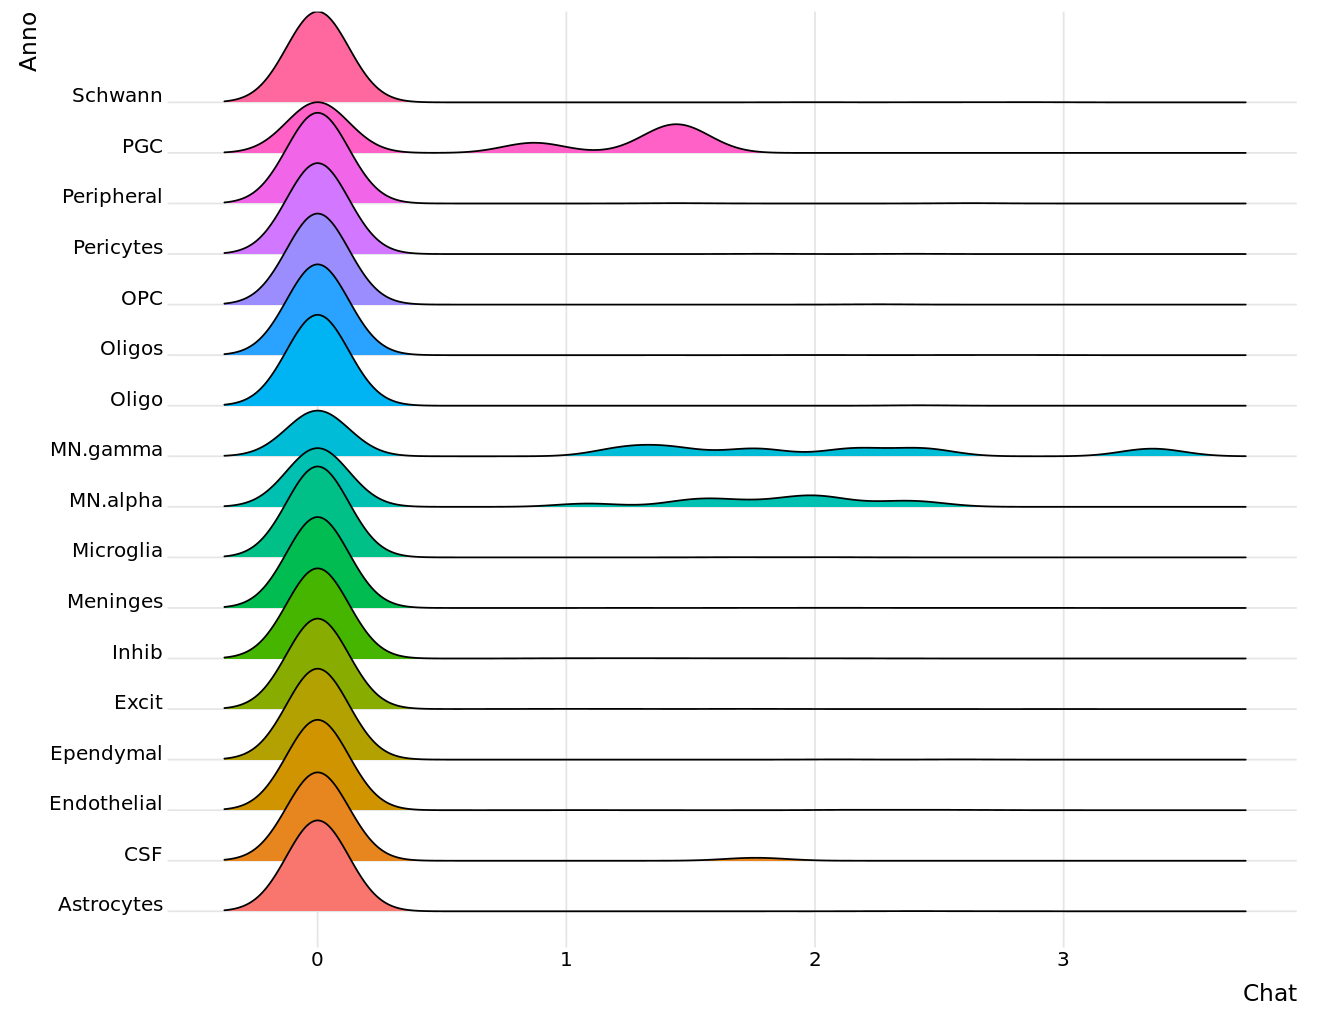

In [21]:
ggplot(sub_mouse_rna, aes(x = Chat, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

In [22]:
sub_mouse_rna$Prph <- mouse_rna[['RNA']]$data['Prph', ]

Picking joint bandwidth of 0.176



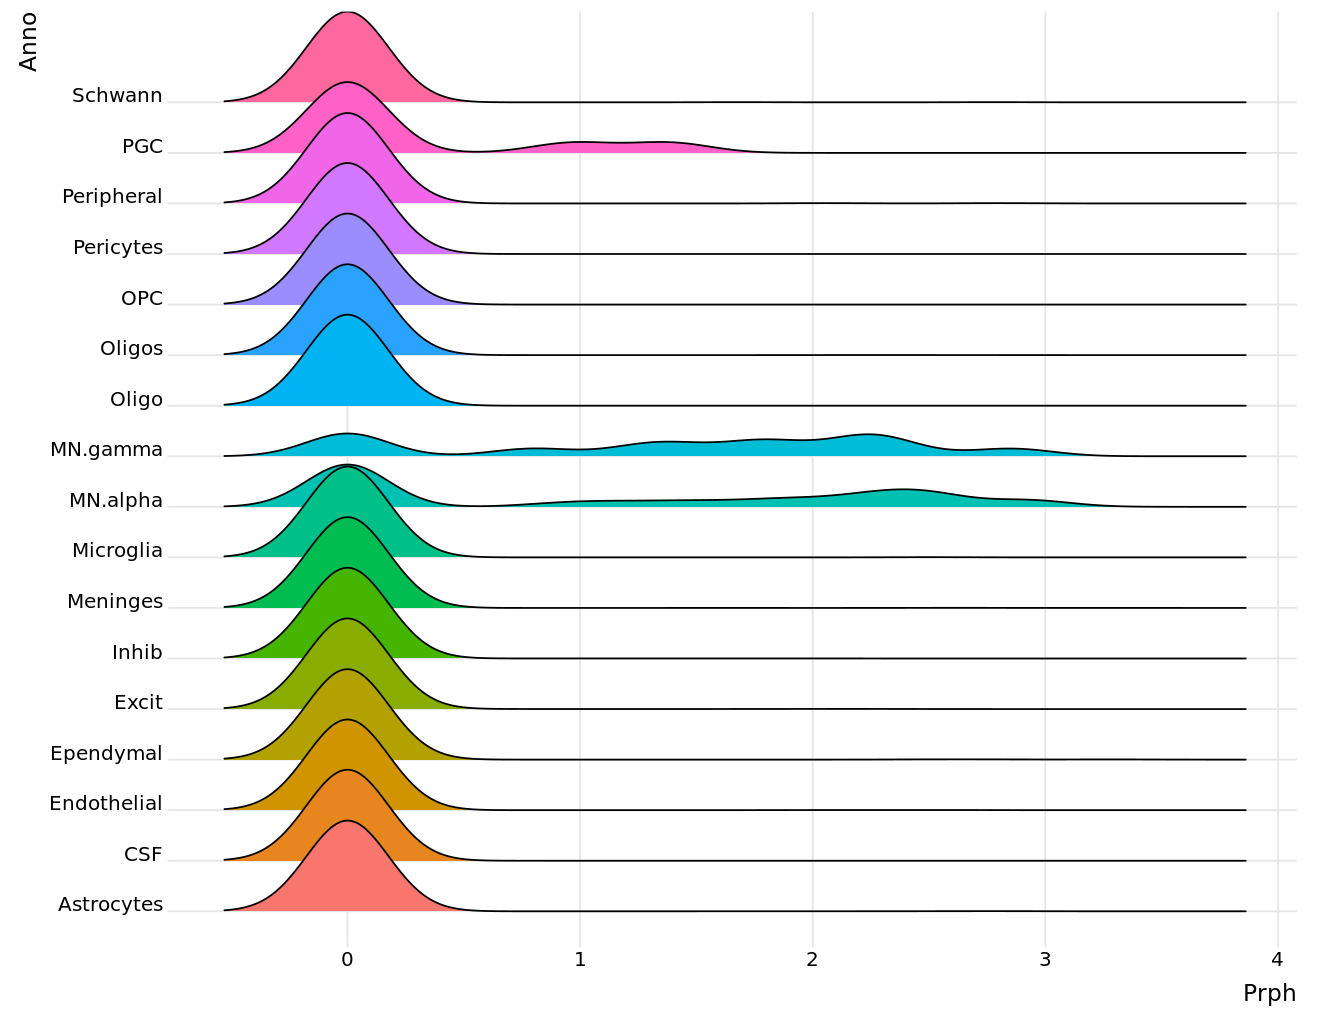

In [23]:
ggplot(sub_mouse_rna, aes(x = Prph, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

In [24]:
sub_mouse_rna$Nrp2 <- mouse_rna[['RNA']]$data['Nrp2', ]

Picking joint bandwidth of 0.247



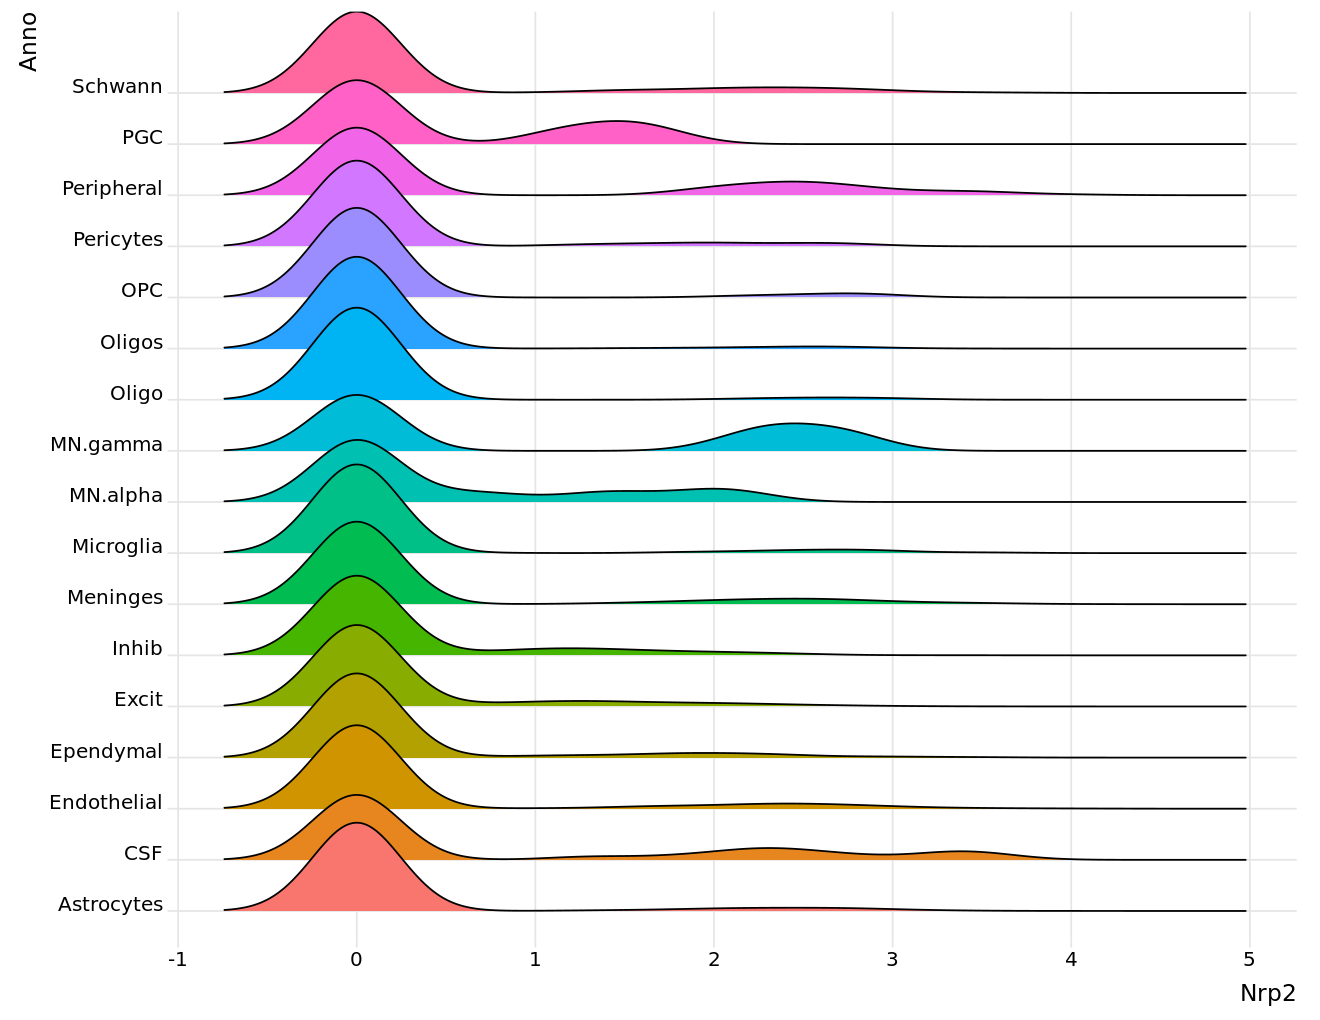

In [25]:
ggplot(sub_mouse_rna, aes(x = Nrp2, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

In [32]:
sub_mouse_rna

,Chat,Anno,Prph,Nrp2
,<dbl>,<chr>,<dbl>,<dbl>
SRR6040902_AGGTCTGTGGAA,0.000000,Oligos,0,0.0000000
SRR6040902_ACAGCGTCATGG,0.000000,Oligos,0,0.0000000
SRR6040902_GGCGCTTAGTGG,0.000000,Meninges,0,0.0000000
SRR6040902_ACAAGTTCGTTG,0.000000,Oligos,0,1.4655683
SRR6040902_ACTTCGTCTTAA,0.000000,Inhib,0,0.0000000
SRR6040902_ATTGTACTGGTA,0.000000,Inhib,0,0.8129494
SRR6040902_TGTCCAAGAATA,0.000000,Excit,0,2.0652225
SRR6040902_ACAGAAACTTCA,0.000000,Oligo,0,0.0000000
SRR6040902_GTAGCTGGGGCN,0.000000,Excit,0,0.0000000


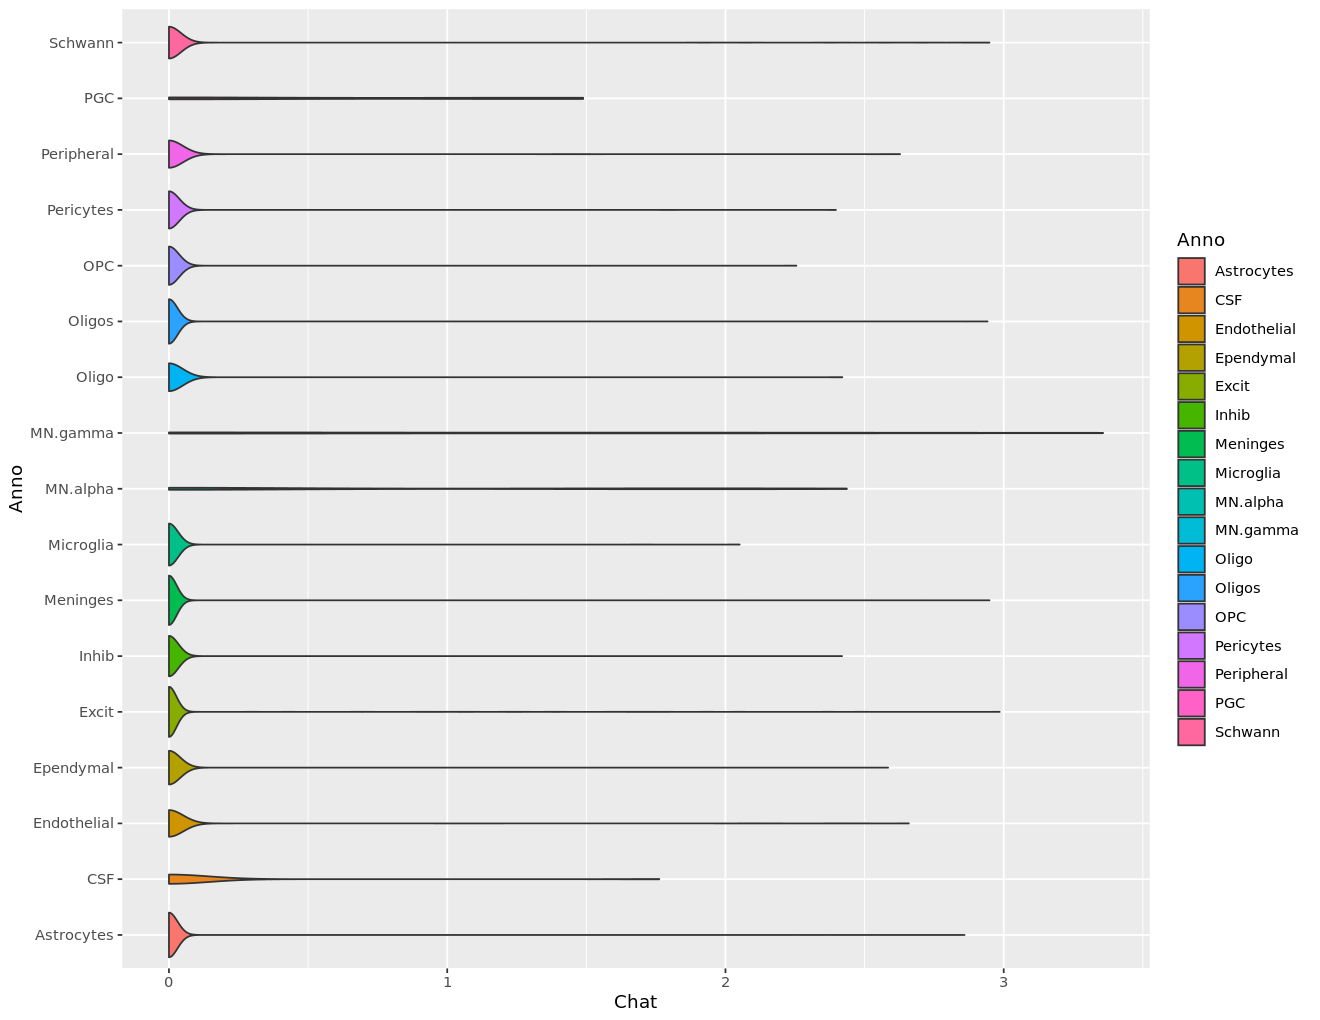

In [34]:
ggplot(sub_mouse_rna, aes(x = Chat, y = Anno, fill = Anno)) + 
  geom_violin()

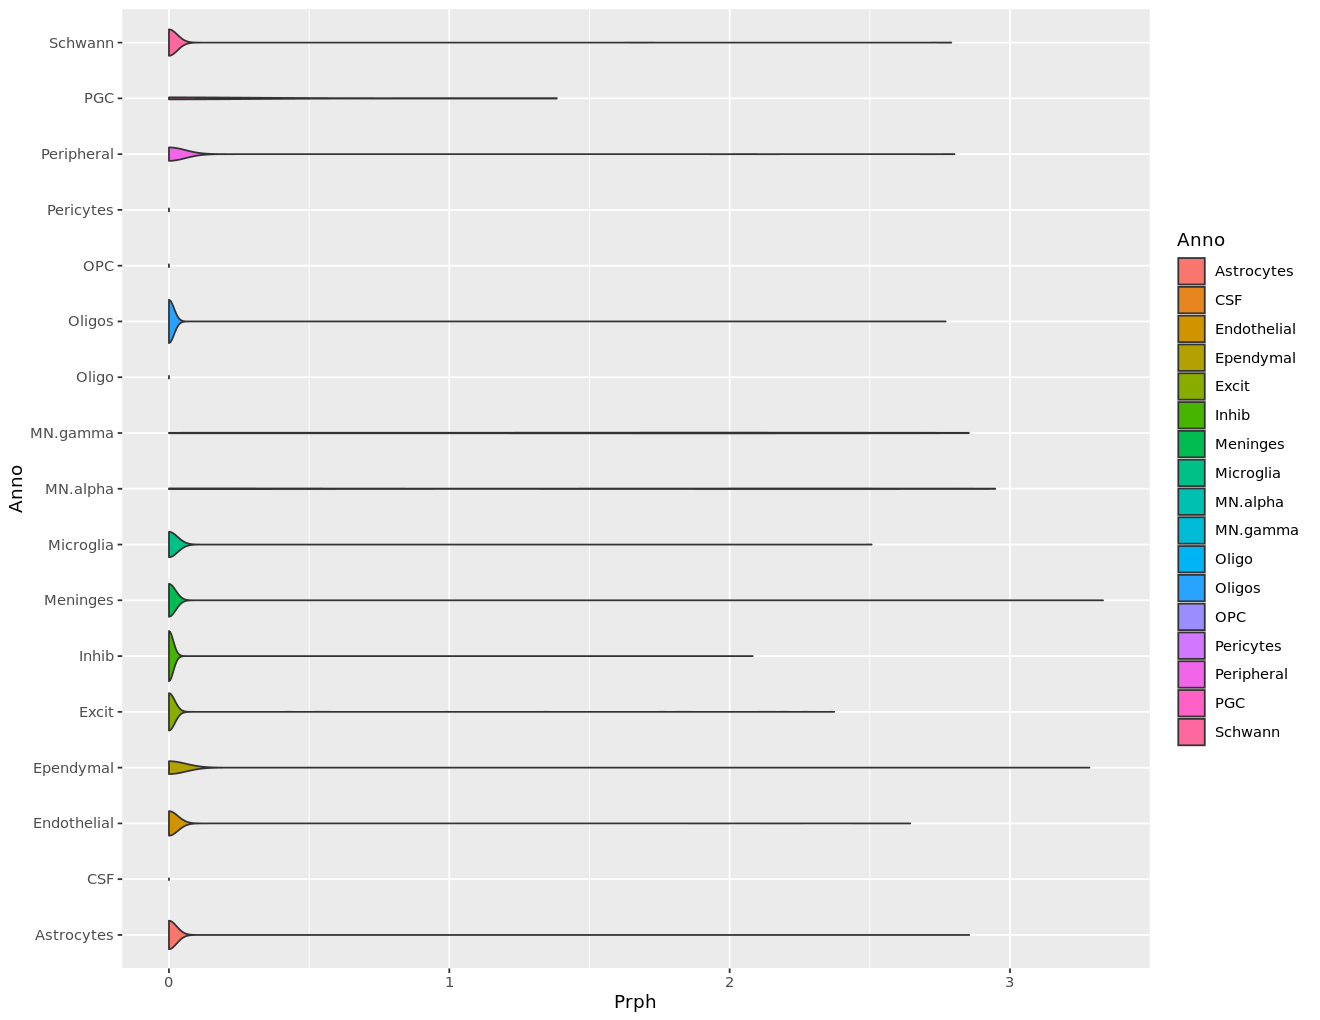

In [35]:
ggplot(sub_mouse_rna, aes(x = Prph, y = Anno, fill = Anno)) + 
  geom_violin()

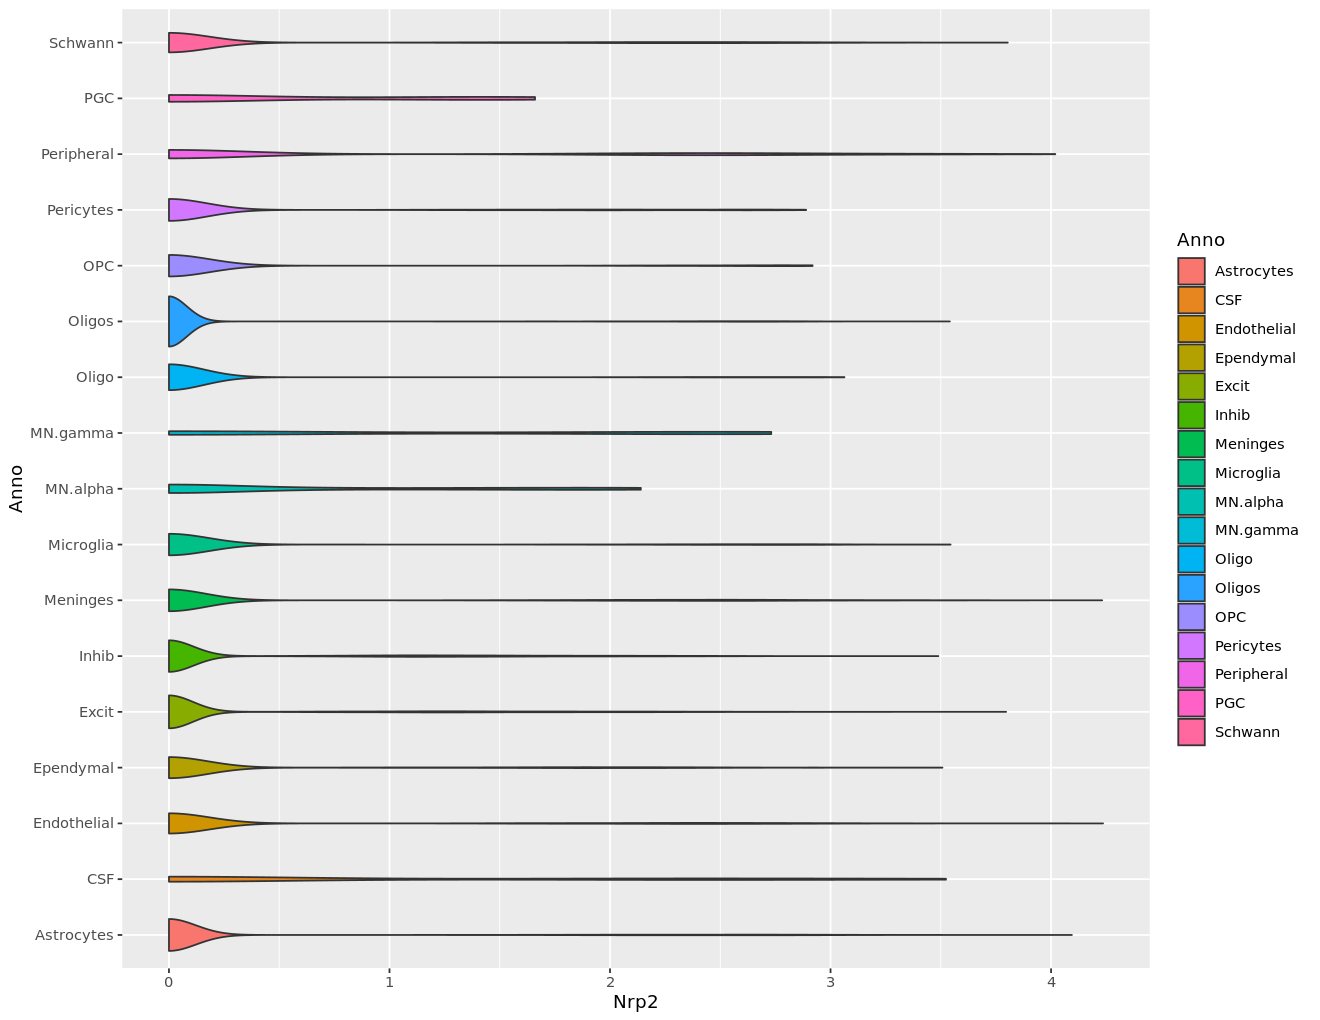

In [36]:
ggplot(sub_mouse_rna, aes(x = Nrp2, y = Anno, fill = Anno)) + 
  geom_violin()

Additionally, I created violin plots of the same data to determine if this visualization method provides clearer insights compared to ridge plots.

# The cell types of interest were found to be PGC and motor neurons (alpha and gamma).